In [1]:
import math
import csv
from collections import OrderedDict, deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from IPython.display import clear_output, HTML, display
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation

# ---------------------------------------------------------------------
# Setup
# ---------------------------------------------------------------------
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng(123)
torch.manual_seed(123)

# ---------------------------------------------------------------------
# Environment
# ---------------------------------------------------------------------
min_position = -0.99
max_position = 0.99
max_speed = 0.07
dt = 0.1
force_mag = 0.001
gravity = 0.0025

min_start_pos = 0.67
max_start_pos = 0.77
max_start_vel = 0.01

state_low = torch.tensor([min_position, -max_speed], device=device)
state_high = torch.tensor([max_position, max_speed], device=device)
state_mid = 0.5 * (state_high + state_low)
state_span = 0.5 * (state_high - state_low)


def normalize_state(states: torch.Tensor) -> torch.Tensor:
    """Scale (pos, vel) to [-1, 1] for the RFF layer."""
    return (states - state_mid) / state_span


box_area = (max_position - min_position) * (2 * max_speed)


def tg_alpha(x: torch.Tensor) -> torch.Tensor:
    return 0.1 * (
        2 * x / (1 - x ** 2)
        - 2 * math.pi * torch.sin(2 * math.pi * x)
        - 8 * math.pi * torch.sin(4 * math.pi * x)
    )


def total_horizontal_force(a: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    # a in {0,1}
    return (a * 2 - 1) * force_mag + tg_alpha(x) * (-gravity)


def next_state(s: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
    """
    s: (N,2) with (x,v)
    a: (N,) 0 or 1
    """
    x = s[:, 0]
    v = s[:, 1]
    f = total_horizontal_force(a.float(), x)

    v = torch.clamp(v + f * dt, -max_speed, max_speed)
    x = torch.clamp(x + v * dt, min_position, max_position)

    return torch.stack([x, v], dim=1)


def sample_proposal(n: int) -> torch.Tensor:
    """Uniform proposal over the state box."""
    u = torch.rand(n, 2, device=device)
    s = state_low + u * (state_high - state_low)
    return s


def sample_start(n: int) -> torch.Tensor:
    """Initial distribution d0."""
    sign = torch.where(
        torch.rand(n, device=device) < 0.5,
        -torch.ones(n, device=device),
        torch.ones(n, device=device)
    )
    pos = (
        sign
        * torch.rand(n, device=device) * (max_start_pos - min_start_pos)
        + sign * min_start_pos
    )
    vel = (torch.rand(n, device=device) * 2 - 1) * max_start_vel
    return torch.stack([pos, vel], dim=1)


def render_state_distribution_video(
    frames,
    extent,
    norm,
    interval_ms=200,
    save_path=None
):
    """Render an HTML5 video showing how the density evolves over time."""
    if not frames:
        return

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')

    im = ax.imshow(
        frames[0][1].T,
        extent=extent,
        origin='lower',
        cmap='gray',
        aspect='auto',
        norm=norm
    )
    title = ax.set_title(f'Learned Distribution (Iteration {frames[0][0]})')

    def update(frame):
        iteration, density_values = frame
        im.set_data(density_values.T)
        title.set_text(f'Learned Distribution (Iteration {iteration})')
        return im,

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=frames,
        interval=interval_ms,
        repeat=False
    )

    fps = max(1, int(1000 / interval_ms)) if interval_ms > 0 else 5

    if save_path:
        target_path = str(save_path)
        if not target_path.lower().endswith('.gif'):
            target_path = f"{target_path}.gif"
        writer = animation.PillowWriter(fps=fps)
        anim.save(target_path, writer=writer)

    html = HTML(anim.to_jshtml())
    plt.close(fig)
    display(html)


# ---------------------------------------------------------------------
# Fixed policy
# ---------------------------------------------------------------------
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self._fc_policy = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self._fc_policy(x)


policy_net = PolicyNetwork().to(device)

# >>> EDIT THIS PATH IF NEEDED <<<
POLICY_STATE_PATH = "/kaggle/input/net/pytorch/default/1/net.pth"

try:
    state_dict = torch.load(POLICY_STATE_PATH, map_location=device)
    policy_state = OrderedDict(
        {
            k.replace('_fc_policy.', ''): v
            for k, v in state_dict.items()
            if k.startswith('_fc_policy')
        }
    )
    policy_net._fc_policy.load_state_dict(policy_state)
    policy_net.eval()
    print(f"Loaded policy from: {POLICY_STATE_PATH}")
except Exception as e:
    print(f"Warning: could not load policy state dict: {e}")
    policy_net.eval()


@torch.no_grad()
def sample_actions(s: torch.Tensor) -> torch.Tensor:
    logits = policy_net(s)
    dist = Categorical(logits=logits)
    return dist.sample()


@torch.no_grad()
def policy_probs(states: torch.Tensor) -> torch.Tensor:
    logits = policy_net(states)
    return F.softmax(logits, dim=-1)


# ---------------------------------------------------------------------
# RealNVP normalizing-flow density (2D)
# ---------------------------------------------------------------------
class RealNVPCoupling(nn.Module):
    def __init__(self, mask: torch.Tensor, hidden: int = 128):
        super().__init__()
        # Ensure mask is a float tensor on the right device
        self.register_buffer("mask", mask.float())  # shape (2,)

        # Convert to Python ints for Linear sizes
        in_dim = int(self.mask.sum().item())              # number of 1's in mask
        out_dim = int((1.0 - self.mask).sum().item())     # number of 0's in mask

        def mlp():
            return nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, out_dim),
            )

        self.s_net = mlp()
        self.t_net = mlp()

    def forward(self, x: torch.Tensor, reverse: bool = False):
        x1 = x * self.mask          # masked part
        x2 = x * (1.0 - self.mask)  # transformed part

        in_s_t = x1[:, self.mask.bool()]          # (N, in_dim)
        s = self.s_net(in_s_t)                    # (N, out_dim)
        t = self.t_net(in_s_t)                    # (N, out_dim)
        s = torch.tanh(s)

        if not reverse:
            y2 = x2[:, (1.0 - self.mask).bool()] * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            y2 = (x2[:, (1.0 - self.mask).bool()] - t) * torch.exp(-s)
            log_det = (-s).sum(dim=1)

        y = x1.clone()
        y[:, (1.0 - self.mask).bool()] = y2
        return y, log_det


class RealNVPDensity(nn.Module):
    """
    RealNVP flow on R^2 with standard Normal base.
    Provides log_prob(x) with the same interface as SiLUDensityRes.
    """
    def __init__(self, dim: int = 2, n_layers: int = 6, hidden: int = 128):
        super().__init__()
        assert dim == 2, "This implementation assumes 2D states."

        masks = []
        base_mask = torch.tensor([1.0, 0.0])
        for i in range(n_layers):
            masks.append(base_mask if i % 2 == 0 else 1.0 - base_mask)

        self.layers = nn.ModuleList(
            [RealNVPCoupling(mask=m, hidden=hidden) for m in masks]
        )

        self.register_buffer("base_mean", torch.zeros(dim))
        self.register_buffer("base_log_std", torch.zeros(dim))  # std = 1
        # Keep a logZ buffer for compatibility with existing train() code;
        # for a normalized flow this stays 0.
        self.register_buffer("logZ", torch.zeros(1))

    def _forward(self, x: torch.Tensor):
        z = x
        log_det_sum = torch.zeros(x.size(0), device=x.device)
        for layer in self.layers:
            z, ld = layer(z, reverse=False)
            log_det_sum += ld
        return z, log_det_sum

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        z, log_det = self._forward(x)
        # Standard Normal log-density
        log_pz = -0.5 * (((z - self.base_mean) / self.base_log_std.exp()) ** 2).sum(dim=1)
        log_pz += -0.5 * x.size(1) * math.log(2 * math.pi)
        return log_pz + log_det - self.logZ

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.log_prob(x)




# ---------------------------------------------------------------------
# Median heuristic for RFF frequencies (3-band sampler)
# ---------------------------------------------------------------------
with torch.no_grad():
    median_sample = sample_proposal(4096)
    median_sample_norm = normalize_state(median_sample)
    pairwise_distances = torch.pdist(median_sample_norm, p=2)
    median_distance = pairwise_distances.median().item()

    # Base frequency std: ~1 / typical distance in normalized space
    rff_sigma_base = (1.0 / max(median_distance, 1e-6))
    rff_sigma_low = 3.0 * rff_sigma_base
    rff_sigma_mid = 15.0 * rff_sigma_base
    rff_sigma_high = 60.0 * rff_sigma_base

    print(f"Median normalized distance: {median_distance:.6f}")
    print(f"RFF sigma base set to {rff_sigma_base:.6f}")
    print(
        f"Low/Mid/High sigmas: "
        f"{rff_sigma_low:.6f}, {rff_sigma_mid:.6f}, {rff_sigma_high:.6f}"
    )


# ---------------------------------------------------------------------
# RFF sampler (3 bands, as in original notebook)
# ---------------------------------------------------------------------
class RFFSampler2D:
    def __init__(
        self,
        sigma_base: float = None,
        device=None,
        dtype=torch.float32
    ):
        self.device = device or torch.device('cpu')
        self.dtype = dtype

        if sigma_base is None:
            if 'rff_sigma_base' not in globals():
                raise ValueError(
                    "Compute rff_sigma_base via the median heuristic cell first."
                )
            sigma_base = float(rff_sigma_base)

        self._set_sigmas(sigma_base)

        print("Initialized RFF Sampler with equal-probability frequency bands:")
        print(f"  LOW : sigma={self.sigma_low.item():.4f}")
        print(f"  MID : sigma={self.sigma_mid.item():.4f}")
        print(f"  HIGH: sigma={self.sigma_high.item():.4f}")

        self.omegas = None
        self.biases = None

    def _set_sigmas(self, sigma_base: float):
        sigma_tensor = torch.tensor(
            sigma_base, device=self.device, dtype=self.dtype
        )
        self.sigma_base = sigma_tensor
        self.sigma_low = 3.0 * sigma_tensor
        self.sigma_mid = 15.0 * sigma_tensor
        self.sigma_high = 60.0 * sigma_tensor

    @property
    def sigma(self) -> torch.Tensor:
        # For logging, expose two representative scales (low/mid).
        return torch.stack([self.sigma_low, self.sigma_mid])

    @torch.no_grad()
    def _band(self, sigma, K, device, dtype):
        return torch.normal(0.0, sigma, (K, 2), device=device, dtype=dtype)

    @torch.no_grad()
    def sample_batch(self, B: int, device=None, dtype=None):
        """Sample B RFFs using an equal-probability mixture of low/mid/high frequencies."""
        device = device or self.device
        dtype = dtype or self.dtype

        B1 = B // 3
        B2 = B // 3
        B3 = B - B1 - B2

        O1 = self._band(self.sigma_low, B1, device, dtype)
        O2 = self._band(self.sigma_mid, B2, device, dtype)
        O3 = self._band(self.sigma_high, B3, device, dtype)

        self.omegas = torch.cat([O1, O2, O3], dim=0)  # (B,2)
        self.biases = 2 * torch.pi * torch.rand(
            B, device=device, dtype=dtype
        )
        return self.omegas, self.biases

    @torch.no_grad()
    def features(
        self,
        states: torch.Tensor,
        omegas: torch.Tensor = None,
        biases: torch.Tensor = None
    ) -> torch.Tensor:
        if omegas is None or biases is None:
            if self.omegas is None or self.biases is None:
                raise ValueError(
                    "Call sample_batch(B) first or supply omegas/biases."
                )
            omegas, biases = self.omegas, self.biases

        states_norm = normalize_state(states)
        proj = states_norm @ omegas.T
        return torch.cos(proj + biases)


# ---------------------------------------------------------------------
# U-gradient estimator
# ---------------------------------------------------------------------
def rff_expect_next_feature(
    states: torch.Tensor,
    probs: torch.Tensor,
    sampler: RFFSampler2D,
    omega: torch.Tensor,
    b: torch.Tensor
) -> torch.Tensor:
    """
    E_a[ f(s⁺) ] under policy.
    """
    N = states.size(0)
    a0 = torch.zeros(N, dtype=torch.long, device=states.device)
    a1 = torch.ones(N, dtype=torch.long, device=states.device)

    sp0 = next_state(states, a0)
    sp1 = next_state(states, a1)

    F_sp0 = sampler.features(sp0, omega, b)
    F_sp1 = sampler.features(sp1, omega, b)

    return probs[:, 0:1] * F_sp0 + probs[:, 1:2] * F_sp1


def estimate_R_and_grad(
    N: int,
    gamma: float,
    sampler: RFFSampler2D,
    omega: torch.Tensor,
    b: torch.Tensor,
    density: nn.Module,
    box_area: float
):
    """
    Compute R_f and its gradient factor via U-gradient.
    """
    # ----- Batch S for R_f -----
    S = sample_proposal(N)
    S0 = sample_start(N)
    pS = policy_probs(S)

    F_S = sampler.features(S, omega, b)  # (N,B)
    EF_Sp = rff_expect_next_feature(S, pS, sampler, omega, b)  # (N,B)
    F_S0 = sampler.features(S0, omega, b)  # (N,B)

    # importance weights w_theta(s); treat as constant for sigma-grad
    with torch.no_grad():
        logw_S = density.log_prob(S) + math.log(box_area)
        w_S = torch.exp(logw_S)

    R_all = (w_S.unsqueeze(1) * (F_S - gamma * EF_Sp)).mean(dim=0) \
            - (1.0 - gamma) * F_S0.mean(dim=0)

    # ----- Independent St for grad -----
    St = sample_proposal(N)
    pSt = policy_probs(St)

    F_St = sampler.features(St, omega, b)
    EF_Stp = rff_expect_next_feature(St, pSt, sampler, omega, b)

    A_f = (F_St - gamma * EF_Stp)

    # importance weights w_theta(s); A_f carries sigma-grad, wt carries theta-grad
    logwt = density.log_prob(St) + math.log(box_area)
    wt = torch.exp(logwt)

    grad_all = (A_f * wt.unsqueeze(1)).mean(dim=0)

    return R_all, grad_all


# ---------------------------------------------------------------------
# Train step (fixed RFF bank)
# ---------------------------------------------------------------------
def train_step(
    N: int,
    gamma: float,
    sampler: RFFSampler2D,
    density: nn.Module,
    optimizer: torch.optim.Optimizer,
    box_area: float,
    B: int
):
    omega, b = sampler.sample_batch(
        B, device=device, dtype=torch.float32
    )

    R_all, grad_all = estimate_R_and_grad(
        N=N, gamma=gamma, sampler=sampler,
        omega=omega, b=b,
        density=density, box_area=box_area
    )

    loss = 2.0 * (R_all * grad_all).mean()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(density.parameters(), max_norm=5.0)
    optimizer.step()

    return loss.item()


# ---------------------------------------------------------------------
# Training loop
# ---------------------------------------------------------------------
def train(
    T=10000, N=15000,
    B=1024,
    gamma=0.99, lr=1e-3,
    print_every=50, visualize_every=200,
    logZ_tau=0.1,
    make_video=True,
    max_video_frames=200,
    video_path=None,
    sigma_update_every=None,
    sigma_sample_size=4096
):
    # visualization grid
    pos_grid = torch.linspace(min_position, max_position, 400, device=device)
    vel_grid = torch.linspace(-max_speed, max_speed, 400, device=device)
    P, V = torch.meshgrid(pos_grid, vel_grid, indexing='ij')
    grid_states = torch.stack((P.flatten(), V.flatten()), dim=1)
    plot_extent = [min_position, max_position, -max_speed, max_speed]

    # CSV logging
    csv_filename = 'training_metrics.csv'
    csv_file = open(csv_filename, 'w', newline='')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(
        ['Iteration', 'Loss', 'MeanWeight', 'BowlWeight', 'BridgeWeight', 'SigmaPos', 'SigmaVel']
    )

    # modules
    # density = SiLUDensityRes(
    #     hidden=512, blocks=5, use_ln=True, box_area=box_area
    # ).to(device)

    density = RealNVPDensity(dim=2, n_layers=10, hidden=128).to(device)

    # Three-band fixed RFF sampler using median-heuristic base sigma.
    sampler = RFFSampler2D(device=device)

    # Only density parameters are optimized; RFF test functions (and their sigmas)
    # stay fixed so the weak-form objective matches the intended theory.
    optimizer = torch.optim.Adam(density.parameters(), lr=lr)

    plot_norm = colors.PowerNorm(gamma=0.4, vmin=0.0, vmax=100.0)
    video_frames = deque(
        maxlen=max_video_frames if max_video_frames else None
    ) if make_video else None

    hist = []
    for t in range(1, T + 1):
        L_val = train_step(
            N=N, gamma=gamma,
            sampler=sampler, density=density,
            optimizer=optimizer, box_area=box_area,
            B=B
        )
        hist.append(L_val)

        # visualization
        if t % visualize_every == 0:
            clear_output(wait=True)
            with torch.no_grad():
                logd = density.log_prob(grid_states)
                d_values = torch.exp(logd).cpu().numpy().reshape(400, 400)

            if video_frames is not None:
                video_frames.append((t, d_values.copy()))

            print(f"Iteration {t}/{T}: L_est={L_val:.6f}")
            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(
                d_values.T,
                extent=plot_extent,
                origin='lower',
                cmap='gray',
                aspect='auto',
                norm=plot_norm
            )
            plt.colorbar(im, ax=ax)
            ax.set_xlabel('Position')
            ax.set_ylabel('Velocity')
            ax.set_title(f'Learned Distribution (Iteration {t})')
            plt.show()
            plt.close()

        # logging + logZ update
        if t % print_every == 0:
            with torch.no_grad():
                s_chk = sample_proposal(200_000)
                logw_c = density.log_prob(s_chk) + math.log(box_area)

                logw_clamped = torch.clamp(logw_c, min=-8.0, max=8.0)
                w_c = torch.exp(logw_clamped)

                # numerically stable estimate of E_m[w]
                shift = logw_c.max()
                w_mean = (
                    torch.exp(logw_c - shift).mean() * torch.exp(shift)
                ).item()

                # logZ := logZ + τ * log(E_m[w]) so mass is nudged toward 1
                delta_logZ = math.log(max(w_mean, 1e-6))
                density.logZ.add_(logZ_tau * delta_logZ)

                # snapshot current per-dimension RFF sigmas
                sigma_vals = sampler.sigma.detach().cpu().tolist()

            print(
                f"Iteration {t}/{T}: L_est={L_val:.6f} | "
                f"E_m[w]≈{w_mean:.3f} | "
                f"sigma={sigma_vals}",
                end='',
                flush=True
            )

            with torch.no_grad():
                bowl_mask = s_chk[:, 0].abs() > 0.6
                bridge_mask = s_chk[:, 0].abs() < 0.3
                w_bowls = (
                    w_c[bowl_mask].mean().item()
                    if bowl_mask.sum() > 0 else 0.0
                )
                w_bridge = (
                    w_c[bridge_mask].mean().item()
                    if bridge_mask.sum() > 0 else 0.0
                )

                print(
                    f"\n--- Weight Check (Iter {t}): "
                    f"Avg Bowl Weight = {w_bowls:.4f} | "
                    f"Avg Bridge Weight = {w_bridge:.4f} ---"
                )

                csv_writer.writerow([t, L_val, w_mean, w_bowls, w_bridge, sigma_vals[0], sigma_vals[1]])
                csv_file.flush()

    csv_file.close()
    print(f"\nTraining complete. Metrics saved to {csv_filename}")

    if video_frames:
        render_state_distribution_video(
            list(video_frames),
            extent=plot_extent,
            norm=plot_norm,
            save_path=video_path
        )

    return hist, density

Loaded policy from: /kaggle/input/net/pytorch/default/1/net.pth
Median normalized distance: 1.015062
RFF sigma base set to 0.985161
Low/Mid/High sigmas: 2.955484, 14.777421, 59.109684


Iteration 5800/50000: L_est=-0.000001


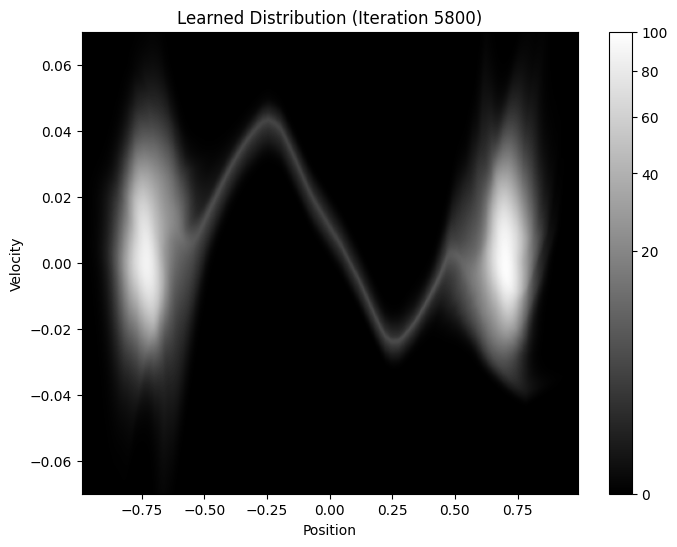

Iteration 5800/50000: L_est=-0.000001 | E_m[w]≈0.993 | sigma=[2.955484390258789, 14.777420997619629]
--- Weight Check (Iter 5800): Avg Bowl Weight = 2.3537 | Avg Bridge Weight = 0.0325 ---
Iteration 5850/50000: L_est=0.000002 | E_m[w]≈0.992 | sigma=[2.955484390258789, 14.777420997619629]
--- Weight Check (Iter 5850): Avg Bowl Weight = 2.3209 | Avg Bridge Weight = 0.0398 ---


KeyboardInterrupt: 

In [2]:
history, density = train(T=50000, N=20000, B=16000, print_every=50, visualize_every=200,
                         gamma=0.99, lr=5e-4, logZ_tau=0.0)